## Numerical Tic-Tac-Toe Agent
- You can play the game here: https://www.flashgamesplayer.com/free/numeric-tic-tac-toe/play.html to understand the rules
- Build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. 
- The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. 

The following is the layout of the notebook:
- Defining epsilon-greedy strategy
- Tracking state-action pairs for convergence
- Define hyperparameters for the Q-learning algorithm
- Generating episode and applying Q-update equation
- Checking convergence in Q-values

#### Importing libraries

In [1]:
# !pip install gym

In [2]:
from TCGame_Env import TicTacToe # importing environment

import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [3]:
env = TicTacToe()

In [4]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [5]:
# Function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [6]:
# Function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [7]:
# printing the default tic tac toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [8]:
# Printing all the valid actions
print(valid_actions(env.state))

[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


#### Epsilon-greedy strategy

In [9]:
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        
        # Exploitation: this gets the action corresponding to max q-value of current state
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else: 
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence

In [10]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [11]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-2-x-x-x-x',(7,5)),('x-5-8-x-x-x-x-x-x',(4,1))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        
        # an array which will have appended values of that state-action pair after every X number of episodes (specified later)
        States_track[state][action] = [] 

In [12]:
initialise_tracking_states()

#### Function to save the Q-dictionary as a pickle file

In [13]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Function to save tracking states

In [14]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Hyperparameters

In [15]:
EPISODES = 5000000
LR = 0.01
GAMMA = 0.9

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001
threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 3000    #every these many episodes, the Q-dict will be updated

### Q-update loop

In [1]:
start_time = time.time()
from tqdm import tqdm

for episode in tqdm(range(EPISODES)):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    terminal_state = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while not terminal_state:  
        curr_state1 = Q_state(curr_state)
        
        # applying epislon method
        curr_action = epsilon_greedy(curr_state, episode) 
        
        next_state, reward, terminal_state = env.step(curr_state, curr_action) 
        next_state_temp = Q_state(next_state)
        
        add_to_dict(next_state)

        # Updating rules
        if not terminal_state:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
            # this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')

    if ((episode+1)% policy_threshold) == 0:  #every 3000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
        

elapsed_time = time.time() - start_time

print('Time Taken', elapsed_time)

save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')

<class 'NameError'>: name 'time' is not defined

#### Check the Q-dictionary

In [17]:
# Q_dict

In [18]:
len(Q_dict)

1428776

##### Checking for one of the states - that which action the agent thinks is the best

In [41]:
Q_dict["1-x-x-9-x-x-6-4-x"]

{(1, 3): -0.01,
 (1, 5): -0.01,
 (1, 7): -0.01,
 (2, 3): 0,
 (2, 5): 0,
 (2, 7): 0,
 (4, 3): 0,
 (4, 5): 0,
 (4, 7): 0,
 (5, 3): 0,
 (5, 5): 0,
 (5, 7): 0,
 (8, 3): 0,
 (8, 5): 0,
 (8, 7): 0}

In [29]:
# type(Q_dict["x-x-4-x-x-1-x-x-x"])
max(Q_dict["x-x-4-x-x-1-x-x-x"], key=Q_dict["x-x-4-x-x-1-x-x-x"].get)

(4, 9)

#### Check the states tracked for Q-values convergence
- Code for plotting the graphs for state-action pairs tracked

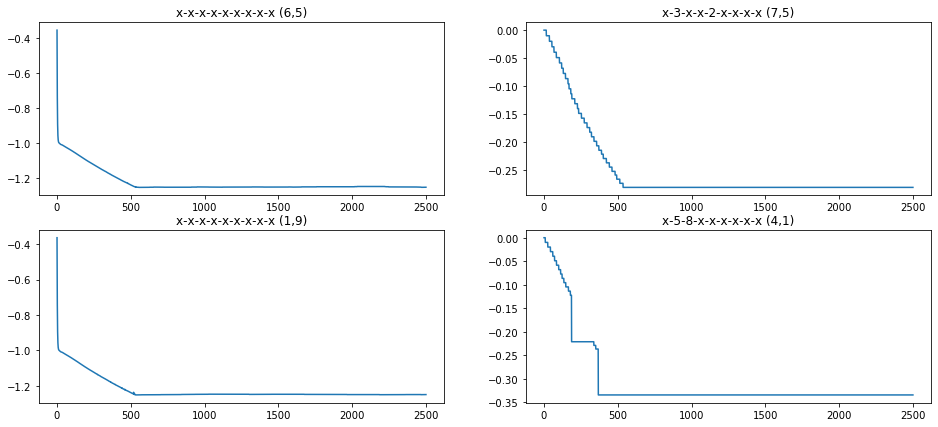

In [20]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.title('x-x-x-x-x-x-x-x-x (6,5)')
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-2-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.title('x-3-x-x-2-x-x-x-x (7,5)')
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-2-x-x-x-x'][(7,5)]))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.title('x-x-x-x-x-x-x-x-x (1,9)')
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))

x_axis = np.asarray(range(0, len(States_track['x-5-8-x-x-x-x-x-x'][(4,1)])))
plt.subplot(224)
plt.title('x-5-8-x-x-x-x-x-x (4,1)')
plt.plot(x_axis,np.asarray(States_track['x-5-8-x-x-x-x-x-x'][(4,1)]))
plt.show()

### Epsilon - decay check

In [21]:
time = np.arange(0,EPISODES)
epsilon = []
for i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

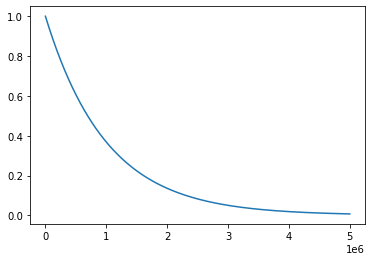

In [22]:
plt.plot(time, epsilon)
plt.show()